### Catalog Analysis
Now we will want to create a catalog of objects that we have detected and give them labels. Here, Python can recognise the shapes of these objects and give us a bunch of useful data such as shape and flux. We also want to create cutouts of the image, cenetred on each source so that they can be catalogued.

In [1]:
# Importing modules
from photutils.segmentation import SourceCatalog
from astropy.io import fits
import matplotlib.pyplot as plt
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from astropy.nddata import Cutout2D 
import numpy as np
from  astropy.visualization import make_lupton_rgb 
from photutils.background import Background2D, MedianBackground
from astropy.stats import SigmaClip

image_dir="../test_data/" #Setting up image directory.

Now we must open our data as we have done in the previous notebooks to obtain our deblended source map and the significance map. Then we can use a feature of Astropy which will generate a catalog of our data and include useful information such as shape and flux.

In [36]:

threshold=3.5 #The threshold above background level for a pixel to be determined to be a source. 

data = fits.open(f"{image_dir}f200w_i2d.fits")   #Opening our file 

sci = data['SCI'].data  #Defining our science map
err = data['ERR'].data  #Defining our error map
sig=sci/err
#-Setting up background removal

bg_est=MedianBackground()
sig_clip=SigmaClip(sigma=3.0)
bg=Background2D(sig.data,box_size=(50,50),filter_size=(3,3),bkg_estimator=bg_est,sigma_clip=sig_clip)
sig=sig.data-bg.background


seg_image=detect_sources(sig, threshold, npixels=5)  #Creating segmentation image
deblend_map=deblend_sources(sci,seg_image,npixels=5) #Using segmentation image to create deblended image

catalog=SourceCatalog(sci,deblend_map)  # This will generate our catalog of data which will be printed below.
print(catalog)
tbl = catalog.to_table() # This just converts the catalog data into a table for ease of viewing.
print("-------------------------")
print("Detected objects data table")
print(tbl)


#-This data will be useful later when we create our cutouts-
labels=np.array(tbl["label"])
x_vals=np.array(tbl["xcentroid"])
y_vals=np.array(tbl["ycentroid"])
x_sise=np.array(tbl["bbox_xmax"]-tbl["bbox_xmin"])
y_sise=np.array(tbl["bbox_ymax"]-tbl["bbox_ymin"])
fluxes=np.array(tbl["kron_flux"])



<photutils.segmentation.catalog.SourceCatalog>
Length: 148
labels: [  1   2   3   4   5 ... 144 145 146 147 148]
-------------------------
Detected objects data table
label     xcentroid          ycentroid      ...     kron_flux      kron_fluxerr
                                            ...                                
----- ------------------ ------------------ ... ------------------ ------------
    1  668.3602391782583 29.629522277404245 ...  2.710611693307568          nan
    2  613.4446663789357  38.27139179697073 ...   3.76686983507523          nan
    3  189.4721458179683   41.6080357521892 ...  5.042253884748193          nan
    4  574.2645057696843  48.42722053101758 ... 2.4950346183655414          nan
    5 183.04683956162134  64.44315728867345 ... 3.6762343248925835          nan
    6  606.7819389162248  64.65629994898885 ...  9.426397275583557          nan
    7 268.20092997149027  91.62376016177046 ... 2.5208199169589953          nan
    8  998.2537650225564 128.6425

So here is our table containing our data. We can now plot elipses around our maps known as Kron Apeteurs. As well as a histogram of the Kron fluxes in the image.

Text(0.5, 0, 'Log10 (Kron_Flux)')

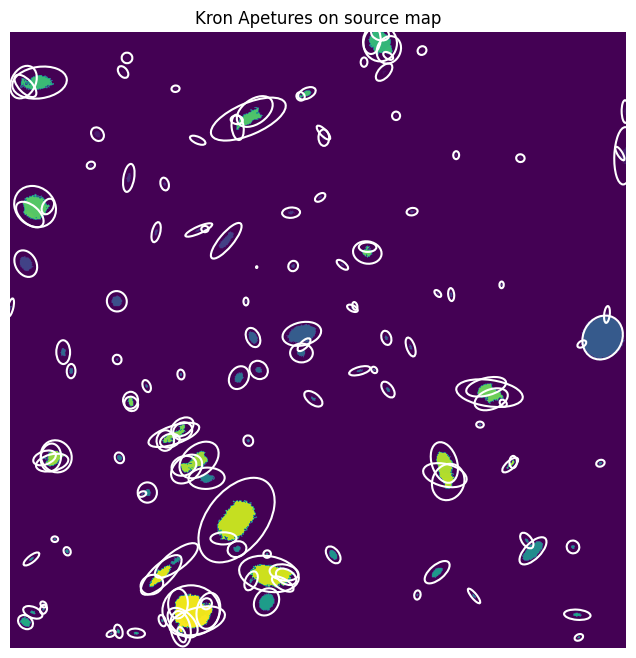

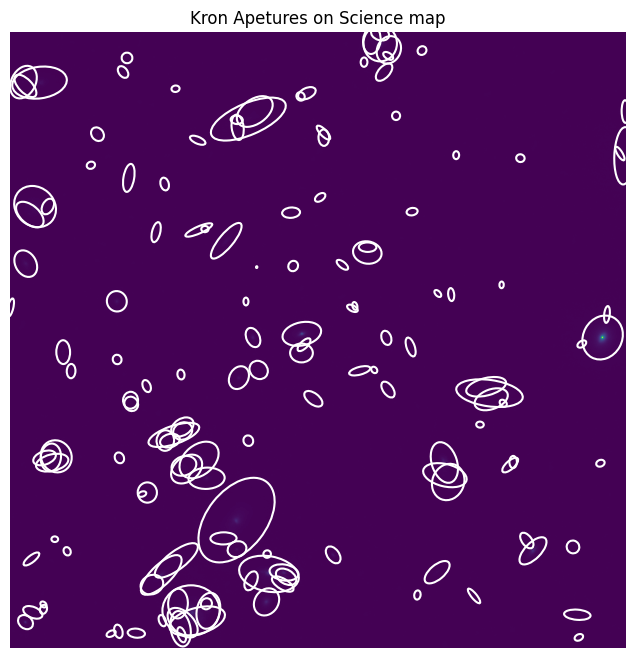

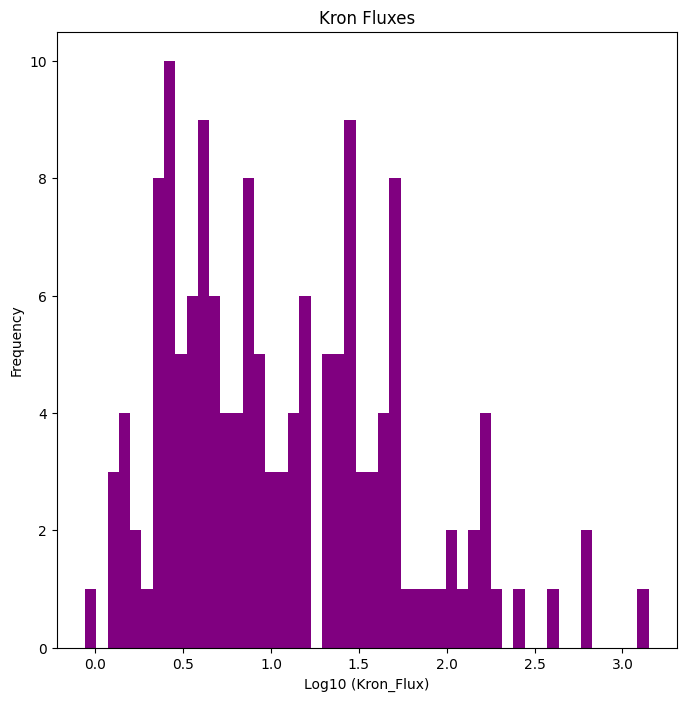

In [45]:
#-Creating figures and plotting our maps-
fig,ax=plt.subplots(1,1,figsize=(8,8))
fig1,ax1=plt.subplots(1,1,figsize=(8,8))
ax.set_axis_off()
ax1.set_axis_off()
ax.imshow(deblend_map)
ax1.imshow(sci)
catalog.plot_kron_apertures(ax=ax, color='white', lw=1.5)
catalog.plot_kron_apertures(ax=ax1, color='white', lw=1.5)
ax.set_title("Kron Apetures on source map")
ax1.set_title("Kron Apetures on Science map")

fig2,ax2=plt.subplots(1,1,figsize=(8,8))
plt.hist(np.log10(fluxes),bins=50,color="Purple")
ax2.set_title("Kron Fluxes")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Log10 (Kron_Flux)")




### Creating the 2D cutouts
Now we will use the data from the catalog table which will include the center pixel coordinates for each object and its boundary box sise which we will use to guage the sise of the cutout. We will then cutout images of each object and create an RGB image for each object. 
We must also remove background noise like we did earlier in the source detection tutorial.

The Cutouts will not be displayed in this notebook but will be saved to the image folder in the workshop folder. This is to prevent Python from crashing. 

The object the title is refering to will be in the center of the image, other objects may appear in the image too if they are close together.
Please note the next box of code will take some time to run depending on your computer.

In astronomy, objects are given a number and a prefix. For example NGC being the New General Catalog and the famous Messier catalog. However we will just be using "Object" as our prefix followed by a number defined in the "labels" list.

In [13]:
#-opening our science maps to create our RGB cutouts.
RGB=['f200w','f150w','f115w'] #These are will be the filters we will use to represent RGB colours respectively.
RGB_maps=[] # A list to contain the three RGB maps.
brightness=1 #This can be used to adjust brighness if needed.

#-Setting up background removal-
bg_est=MedianBackground()
sig_clip=SigmaClip(sigma=3.0)


#-Extracting our data for our RGB colour scheme as done before in image analysis-
counter=0
for n in range(len(RGB)): #Looping over the fiters and extracting the data for the colours.
    temp=fits.open(f"{image_dir}/{RGB[counter]}_i2d.fits")
    temp_data=temp["SCI"].data
    RGB_maps.append(temp_data)
    counter=counter+1


#-List of coordinates for center of sources and their labels
labels
x_vals=x_vals.astype(int)
y_vals=y_vals.astype(int)
#-lists of our boundary box sises
x_sise=x_sise+5 #Adding a small amount to the box sise to make sure we dont cut the image off.
y_sise=y_sise+5

counter=0
print(f"Creating cutouts for {len(labels)} objects")

#-Creating a loop to create the cutouts for every object detected by our source detection-.
for n in range(len(labels)):
    cut_r= Cutout2D(RGB_maps[0],position=(x_vals[counter],y_vals[counter]),size=(x_sise[counter],y_sise[counter])) #Red colourmap cutout
    cut_g= Cutout2D(RGB_maps[1],position=(x_vals[counter],y_vals[counter]),size=(x_sise[counter],y_sise[counter])) #Green colourmap cutout
    cut_b= Cutout2D(RGB_maps[2],position=(x_vals[counter],y_vals[counter]),size=(x_sise[counter],y_sise[counter])) #Blue colourmap cutout

    img=make_lupton_rgb(image_r=cut_r.data,image_g=cut_g.data,image_b=cut_b.data,minimum=0,stretch=1)  #Creating the RGB image
    img=img*brightness  #Adjusting for brightness is needed


    #-Creating and saving figure
    fig,ax=plt.subplots(1,1,figsize=(10,10))
    title="Object",labels[counter]
    save_title=f"../Images/Object_{labels[counter]}_.png"
    ax.set_title(title)
    ax.set_axis_off()
    plt.imshow(img)
    plt.savefig(save_title)
    plt.close()

    counter=counter+1 
print("Done!")
print("Saved cutouts to: (../Images/) in workshop folder")

Creating cutouts for 148 objects
Done!
Saved cutouts to: (../Images/) in workshop folder
